In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv("insurance (1).csv")

In [ ]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Dataset shape: (1338, 7)
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Training Linear Regression...
Linear Regression - MAE: 4181.19, RMSE: 5796.28, R2: 0.7836

Tuning Random Forest (Grid Search)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF params: {'regressor__max_depth': 8, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Best CV MAE: 2626.513335550088
Random Forest - MAE: 2437.41, RMSE: 4407.97, R2: 0.8748

Model comparison on test s

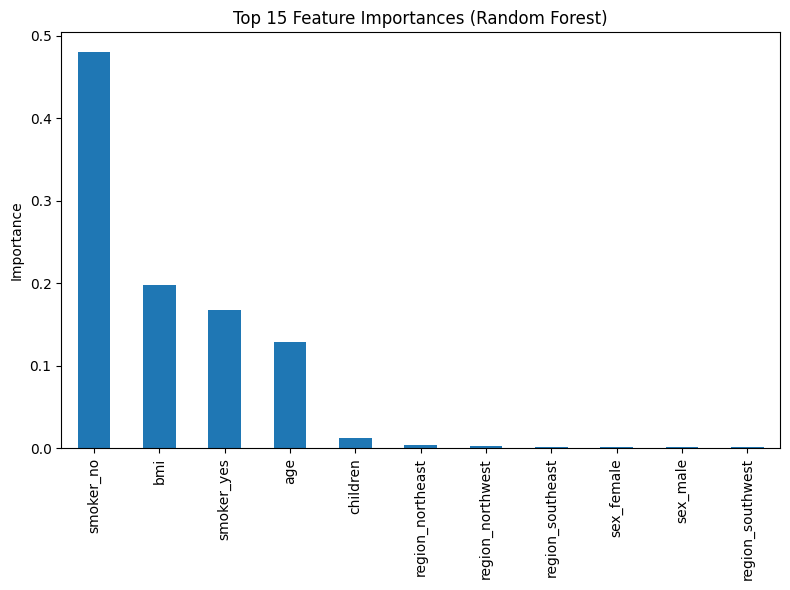


Saved best model to: models/best_insurance_model.joblib


In [ ]:
# insurance_charges_model.py
# Requirements:
# pip install numpy pandas scikit-learn matplotlib joblib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import os

# --- 1) Load data ---
# Assumes file 'insurance.csv' exists in working directory with columns:
# age, sex, bmi, children, smoker, region, charges
df = pd.read_csv("insurance (1).csv")

# Quick glance
print("Dataset shape:", df.shape)
print(df.head())

# --- 2) Basic cleaning / sanity checks ---
# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())

# If there were missing values, we would impute. This dataset usually has none.
# Ensure correct dtypes
df['sex'] = df['sex'].astype(str)
df['smoker'] = df['smoker'].astype(str)
df['region'] = df['region'].astype(str)

# --- 3) Features & target ---
X = df.drop(columns=["charges"])
y = df["charges"]

# Optionally: create additional features (commented out, but left here if you want to try)
# X['age_bmi_interaction'] = X['age'] * X['bmi']
# X['bmi_over_30'] = (X['bmi'] >= 30).astype(int)

# --- 4) Train / test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 5) Preprocessing pipeline ---
numeric_features = ["age", "bmi", "children"]
categorical_features = ["sex", "smoker", "region"]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# --- 6) Model pipelines ---
# Linear Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# --- 7) Train and evaluate Linear Regression ---
print("\nTraining Linear Regression...")
lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr)) # Corrected line
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R2: {r2_lr:.4f}")

# --- 8) Train and tune Random Forest with GridSearchCV ---
print("\nTuning Random Forest (Grid Search)...")
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [8, 12, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best RF params:", grid_search.best_params_)
print("Best CV MAE:", -grid_search.best_score_)

best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred_rf = best_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf)) # Corrected line
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R2: {r2_rf:.4f}")

# --- 9) Compare results ---
print("\nModel comparison on test set:")
print(f"Linear Regression -> MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R2: {r2_lr:.4f}")
print(f"Random Forest     -> MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R2: {r2_rf:.4f}")

# --- 10) Feature importance (for Random Forest) ---
# We need to get feature names after preprocessing
# Helper to extract feature names from ColumnTransformer + OneHotEncoder
def get_feature_names(column_transformer):
    feature_names = []
    for name, transformer, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if isinstance(transformer, Pipeline):
            # last step
            step = transformer.named_steps[list(transformer.named_steps.keys())[-1]]
        else:
            step = transformer
        if hasattr(step, 'get_feature_names_out'):
            names = step.get_feature_names_out(cols)
        else:
            # numeric scaler or imputer
            names = np.array(cols)
        feature_names.extend(list(names))
    return feature_names

feature_names = get_feature_names(preprocessor)
importances = best_rf.named_steps['regressor'].feature_importances_

# Pair and sort
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nTop feature importances (Random Forest):")
print(feat_imp.head(20))

# Plot feature importances
plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# --- 11) Save the best model and preprocessing together ---
output_dir = "models"
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, "best_insurance_model.joblib")
joblib.dump(best_rf, model_path)
print(f"\nSaved best model to: {model_path}")

# --- 12) Example: load & predict with saved model ---
# loaded = joblib.load(model_path)
# sample = X_test.iloc[:5]
# print("Sample predictions:", loaded.predict(sample))